In [33]:
# %% [markdown]
# # Part 1: BBC News Classification Using Matrix Factorization
# Source: https://www.kaggle.com/c/learn-ai-bbc


# **Files:**
# - bbc_news_train.csv (1490 records: ArticleId, Article, Category)
# - bbc_news_test.csv (736 records: ArticleId, Text)
# - bbc_news_sample_solution.csv (sample submission format)
#
# **Objective:**
# - Build a system to classify unseen news articles.
# - Use matrix factorization (NMF) as an unsupervised step to extract latent topics from text and then classify.
# - Compare with a supervised approach (direct TF-IDF).
# - Experiment with hyperparameters and data efficiency.
# - Generate a submission file with predictions.

# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [34]:
# %% [markdown]
# ## 1. Data Loading and Train-Validation Split
#
# Load the training data from **bbc_news_train.csv**.
# The file contains: ArticleId, Article, Category.
# For internal evaluation, we split into training and validation sets.

# %% [code]
# Load training data
bbc_train = pd.read_csv('./data/bbc/bbc_news_train.csv')
print("Training data shape:", bbc_train.shape)
print(bbc_train.head(1))

# Stratified split (80% train, 20% validation)
train_df, val_df = train_test_split(bbc_train, test_size=0.2, random_state=42, stratify=bbc_train['Category'])
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)


Training data shape: (1490, 3)
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
Train set shape: (1192, 3)
Validation set shape: (298, 3)


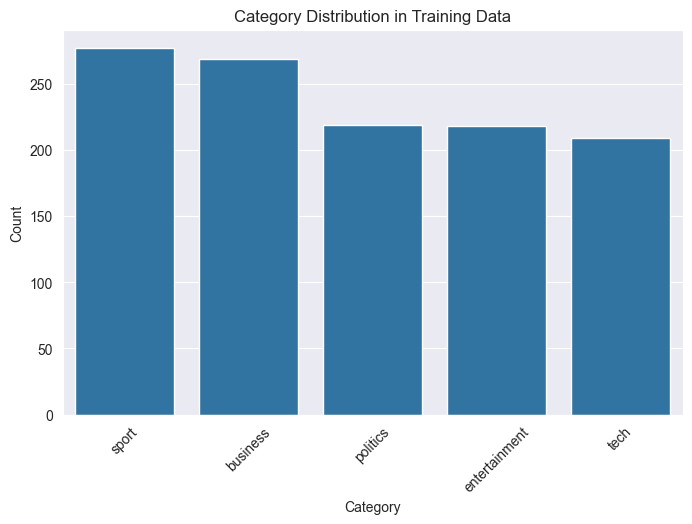

In [35]:
# %% [markdown]
# ## 2. Exploratory Data Analysis (EDA)
#
# Visualize the category distribution in the training set.

# %% [code]
plt.figure(figsize=(8, 5))
sns.countplot(x='Category', data=train_df, order=train_df['Category'].value_counts().index)
plt.title("Category Distribution in Training Data")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [36]:
# %% [markdown]
# ## 3. Feature Extraction with TF-IDF
#
# **Note:** Fit the vectorizer on the training data (to avoid data leakage) and transform the validation set.
# The text column in training data is "Article".

# %% [code]
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_df['Text'])
X_val = tfidf_vectorizer.transform(val_df['Text'])

print("TF-IDF Train shape:", X_train.shape)
print("TF-IDF Validation shape:", X_val.shape)


TF-IDF Train shape: (1192, 1000)
TF-IDF Validation shape: (298, 1000)


In [37]:
# %% [markdown]
# ## 4. Unsupervised Approach: NMF + Logistic Regression
#
# For various numbers of latent topics (n_components), we:
# - Fit NMF on the training TF-IDF features.
# - Transform both training and validation data.
# - Train Logistic Regression on the NMF features.
# - Record training and validation accuracies.

# %% [code]
n_components_list = [5, 10, 15, 20]
nmf_results = []

for n in n_components_list:
    nmf = NMF(n_components=n, random_state=42, init='nndsvda', max_iter=300)
    W_train = nmf.fit_transform(X_train)
    W_val = nmf.transform(X_val)

    clf = LogisticRegression(max_iter=500)
    clf.fit(W_train, train_df['Category'])

    train_pred = clf.predict(W_train)
    val_pred = clf.predict(W_val)

    train_acc = accuracy_score(train_df['Category'], train_pred)
    val_acc = accuracy_score(val_df['Category'], val_pred)

    nmf_results.append({'n_components': n, 'Train Accuracy': train_acc, 'Validation Accuracy': val_acc})

nmf_results_df = pd.DataFrame(nmf_results)
print("NMF Hyperparameter Results:")
print(nmf_results_df)


NMF Hyperparameter Results:
   n_components  Train Accuracy  Validation Accuracy
0             5        0.901846             0.875839
1            10        0.911074             0.902685
2            15        0.933725             0.912752
3            20        0.921980             0.912752


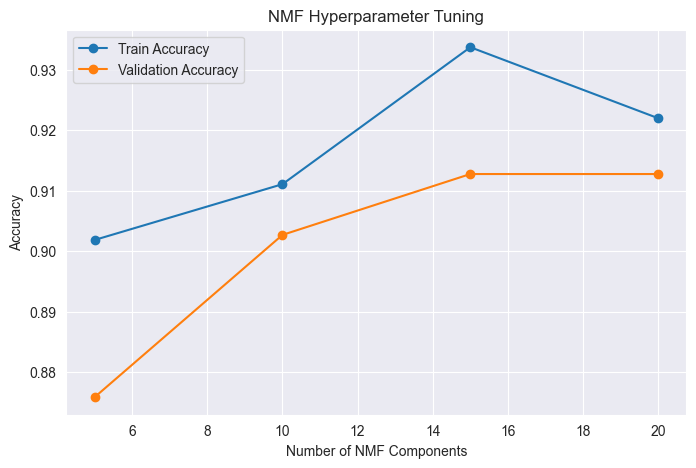

In [38]:
plt.figure(figsize=(8,5))
plt.plot(nmf_results_df['n_components'], nmf_results_df['Train Accuracy'], marker='o', label='Train Accuracy')
plt.plot(nmf_results_df['n_components'], nmf_results_df['Validation Accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Number of NMF Components')
plt.ylabel('Accuracy')
plt.title('NMF Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# %% [markdown]
# ### Detailed Classification Report using NMF Features (n_components = 10)
#
# We choose n_components = 10 and display full classification reports.

# %% [code]
nmf_final = NMF(n_components=10, random_state=42, init='nndsvda', max_iter=300)
W_train_final = nmf_final.fit_transform(X_train)
W_val_final = nmf_final.transform(X_val)

clf_nmf_final = LogisticRegression(max_iter=500)
clf_nmf_final.fit(W_train_final, train_df['Category'])

train_pred_final = clf_nmf_final.predict(W_train_final)
val_pred_final = clf_nmf_final.predict(W_val_final)

print("Classification Report (NMF features) - Train:")
print(classification_report(train_df['Category'], train_pred_final))
print("Classification Report (NMF features) - Validation:")
print(classification_report(val_df['Category'], val_pred_final))


Classification Report (NMF features) - Train:
               precision    recall  f1-score   support

     business       0.84      0.93      0.89       269
entertainment       0.97      0.87      0.92       218
     politics       0.97      0.82      0.89       219
        sport       0.91      1.00      0.95       277
         tech       0.91      0.90      0.91       209

     accuracy                           0.91      1192
    macro avg       0.92      0.91      0.91      1192
 weighted avg       0.92      0.91      0.91      1192

Classification Report (NMF features) - Validation:
               precision    recall  f1-score   support

     business       0.80      0.96      0.87        67
entertainment       1.00      0.87      0.93        55
     politics       0.94      0.80      0.86        55
        sport       0.88      0.99      0.93        69
         tech       0.98      0.87      0.92        52

     accuracy                           0.90       298
    macro avg     

In [40]:
# %% [markdown]
# ## 5. Supervised Approach: TF-IDF + Logistic Regression
#
# Here we train a classifier directly on the TF-IDF features.

# %% [code]
clf_tfidf = LogisticRegression(max_iter=500)
clf_tfidf.fit(X_train, train_df['Category'])

train_pred_tfidf = clf_tfidf.predict(X_train)
val_pred_tfidf = clf_tfidf.predict(X_val)

print("Classification Report (TF-IDF) - Train:")
print(classification_report(train_df['Category'], train_pred_tfidf))
print("Classification Report (TF-IDF) - Validation:")
print(classification_report(val_df['Category'], val_pred_tfidf))


Classification Report (TF-IDF) - Train:
               precision    recall  f1-score   support

     business       0.99      0.99      0.99       269
entertainment       1.00      0.99      0.99       218
     politics       0.99      1.00      0.99       219
        sport       1.00      1.00      1.00       277
         tech       0.99      1.00      0.99       209

     accuracy                           0.99      1192
    macro avg       0.99      0.99      0.99      1192
 weighted avg       0.99      0.99      0.99      1192

Classification Report (TF-IDF) - Validation:
               precision    recall  f1-score   support

     business       0.90      0.96      0.93        67
entertainment       0.98      1.00      0.99        55
     politics       0.96      0.91      0.93        55
        sport       0.99      0.99      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.96       298
    macro avg       0.96      

Data Efficiency Analysis:
   Fraction  Unsupervised (NMF) Acc  Supervised (TF-IDF) Acc
0       0.1                0.788591                 0.916107
1       0.2                0.822148                 0.949664
2       0.5                0.899329                 0.949664
3       1.0                0.902685                 0.956376


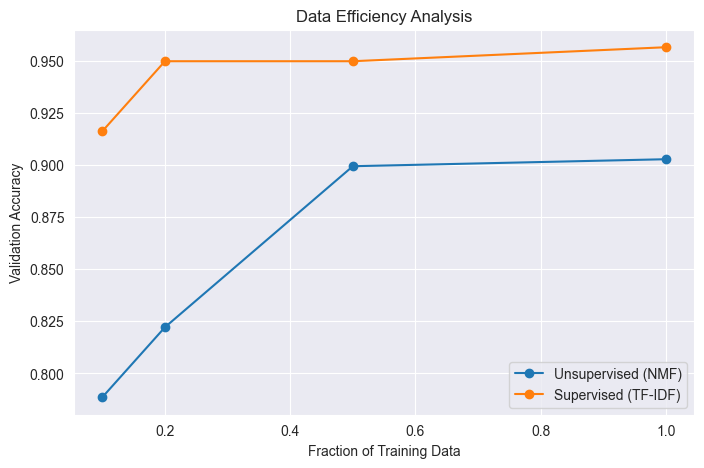

In [41]:
# %% [markdown]
# ## 6. Data Efficiency Analysis
#
# We evaluate performance when training on only a fraction of the training data (10%, 20%, 50%, 100%).
# Both the unsupervised (NMF+LR) and supervised (TF-IDF+LR) approaches are compared.

# %% [code]
fractions = [0.1, 0.2, 0.5, 1.0]
efficiency_results = []

for frac in fractions:
    sub_train = train_df.sample(frac=frac, random_state=42)

    tfidf_sub = TfidfVectorizer(stop_words='english', max_features=1000)
    X_sub = tfidf_sub.fit_transform(sub_train['Text'])
    X_val_sub = tfidf_sub.transform(val_df['Text'])

    # Unsupervised approach
    nmf_sub = NMF(n_components=10, random_state=42, init='nndsvda', max_iter=300)
    W_sub = nmf_sub.fit_transform(X_sub)
    W_val_sub = nmf_sub.transform(X_val_sub)

    clf_nmf_sub = LogisticRegression(max_iter=500)
    clf_nmf_sub.fit(W_sub, sub_train['Category'])
    val_acc_nmf = accuracy_score(val_df['Category'], clf_nmf_sub.predict(W_val_sub))

    # Supervised approach
    clf_tfidf_sub = LogisticRegression(max_iter=500)
    clf_tfidf_sub.fit(X_sub, sub_train['Category'])
    val_acc_tfidf = accuracy_score(val_df['Category'], clf_tfidf_sub.predict(X_val_sub))

    efficiency_results.append({
        'Fraction': frac,
        'Unsupervised (NMF) Acc': val_acc_nmf,
        'Supervised (TF-IDF) Acc': val_acc_tfidf
    })

efficiency_df = pd.DataFrame(efficiency_results)
print("Data Efficiency Analysis:")
print(efficiency_df)

plt.figure(figsize=(8,5))
plt.plot(efficiency_df['Fraction'], efficiency_df['Unsupervised (NMF) Acc'], marker='o', label='Unsupervised (NMF)')
plt.plot(efficiency_df['Fraction'], efficiency_df['Supervised (TF-IDF) Acc'], marker='o', label='Supervised (TF-IDF)')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Validation Accuracy')
plt.title('Data Efficiency Analysis')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# %% [markdown]
# ## 7. Final Test Set Prediction and Submission File
#
# Now load **bbc_news_test.csv** (columns: ArticleId and Text), predict the Category using the chosen model, and create a submission file.

# %% [code]
# Load test data
bbc_test = pd.read_csv('./data/bbc/bbc_news_test.csv')
print("Test data shape:", bbc_test.shape)
print(bbc_test.head(1))


Test data shape: (735, 2)
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...


In [43]:
# Use the supervised TF-IDF classifier for final prediction.
X_test_final = tfidf_vectorizer.transform(bbc_test['Text'])
test_predictions = clf_tfidf.predict(X_test_final)

submission = pd.DataFrame({
    'ArticleId': bbc_test['ArticleId'],
    'Category': test_predictions
})
print("Submission preview:")
print(submission.head())


Submission preview:
   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


In [44]:
# Save submission file (e.g., bbc_news_submission.csv)
submission.to_csv('./data/bbc/bbc_news_submission.csv', index=False)
print("Submission file 'bbc_news_submission.csv' created.")


Submission file 'bbc_news_submission.csv' created.
